In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from urllib.request import urlopen
import json
from sodapy import Socrata
import plotly.express as px
import plotly.graph_objs as go
import matplotlib.pyplot as plt
from country_list import countries_for_language
import unidecode
import topojson
from topojson import geometry
plt.style.use('https://raw.githubusercontent.com/datatrooper/instatrooper/master/styles/whitetrooper.mplstyle')
dp = [
    "#1c1c3c",
    "#967B4F",
    "#46493D",
    "#839DA5",
    "#9FADAD",
    "#2B4144",
    "#986E37"
]
plt.rcParams['axes.grid'] = False

In [2]:
spa = dict(countries_for_language("es"))
for k,v in spa.items():
    spa.update({k: unidecode.unidecode(v.upper())})
    

eng = dict(countries_for_language("en"))

In [3]:
def load_colombia_df():
    client = Socrata("www.datos.gov.co", None)  # https://www.datos.gov.co/es/profile/edit/developer_settings   por si no funciona
    results = client.get("gt2j-8ykr", limit=100000)
    results_df = pd.DataFrame.from_records(results)
    return results_df

In [4]:
df_col = load_colombia_df()

In [5]:
def preprocess_df(df):
    df = df.rename(columns={"fecha_diagnostico": "Fecha de diagnóstico",
                            "ciudad_de_ubicaci_n": "ciudad",
                            "fecha_de_notificaci_n": "Fecha de notificacion",
                            "atenci_n": "atencion"})
    
    df["sexo"] = df["sexo"].str.upper()
    df["estado"] = df["estado"].str.upper()
    df["atencion"] = df["atencion"].str.upper()
    df["tipo"] = df["tipo"].str.upper()
    df["edad"] = df["edad"].astype(int)
    
    df["Fecha de diagnóstico"] = pd.to_datetime(df["Fecha de diagnóstico"], errors="coerce")
    df["fecha_recuperado"] = pd.to_datetime(df["fecha_recuperado"], errors="coerce")
    df["fecha_de_muerte"] = pd.to_datetime(df["fecha_de_muerte"], errors="coerce")
    df.loc[df["fis"]=="Asintomático", "estado"] = "ASINTOMATICO"
    df["fis"] = pd.to_datetime(df["fis"], errors="coerce")
    df["tiempo recuperacion"] = df["fecha_recuperado"] - df["fis"]
    df["tiempo recuperacion"] = df["tiempo recuperacion"].dt.days
    
    df["tiempo muerte"] = df["fecha_de_muerte"] - df["fis"]
    df["tiempo muerte"] = df["tiempo muerte"].dt.days
    return df

In [6]:
df_col = preprocess_df(df_col)

In [9]:
df_ant = df_col[df_col["departamento"] == "Antioquia"]

## Infectados

In [90]:
cuenta = pd.DataFrame(df_ant.groupby("Fecha de diagnóstico")["id_de_caso"].count()).reset_index()
cuenta = cuenta.rename(columns={"id_de_caso":"cuenta"})
idx = pd.date_range(cuenta["Fecha de diagnóstico"].min(), cuenta["Fecha de diagnóstico"].max())
all_dates = pd.DataFrame(idx, columns=["fecha"])
cuenta = all_dates.merge(cuenta, left_on="fecha", 
                right_on="Fecha de diagnóstico", 
                how="left").drop("Fecha de diagnóstico", axis=1).fillna(0)
cuenta["fecha"] = cuenta["fecha"].dt.strftime('%m-%d')
cuenta.head()

,fecha,cuenta
0,03-09,1.0
1,03-10,0.0
2,03-11,3.0
3,03-12,0.0
4,03-13,0.0


In [91]:
cuenta["cuenta"].sum()

509.0

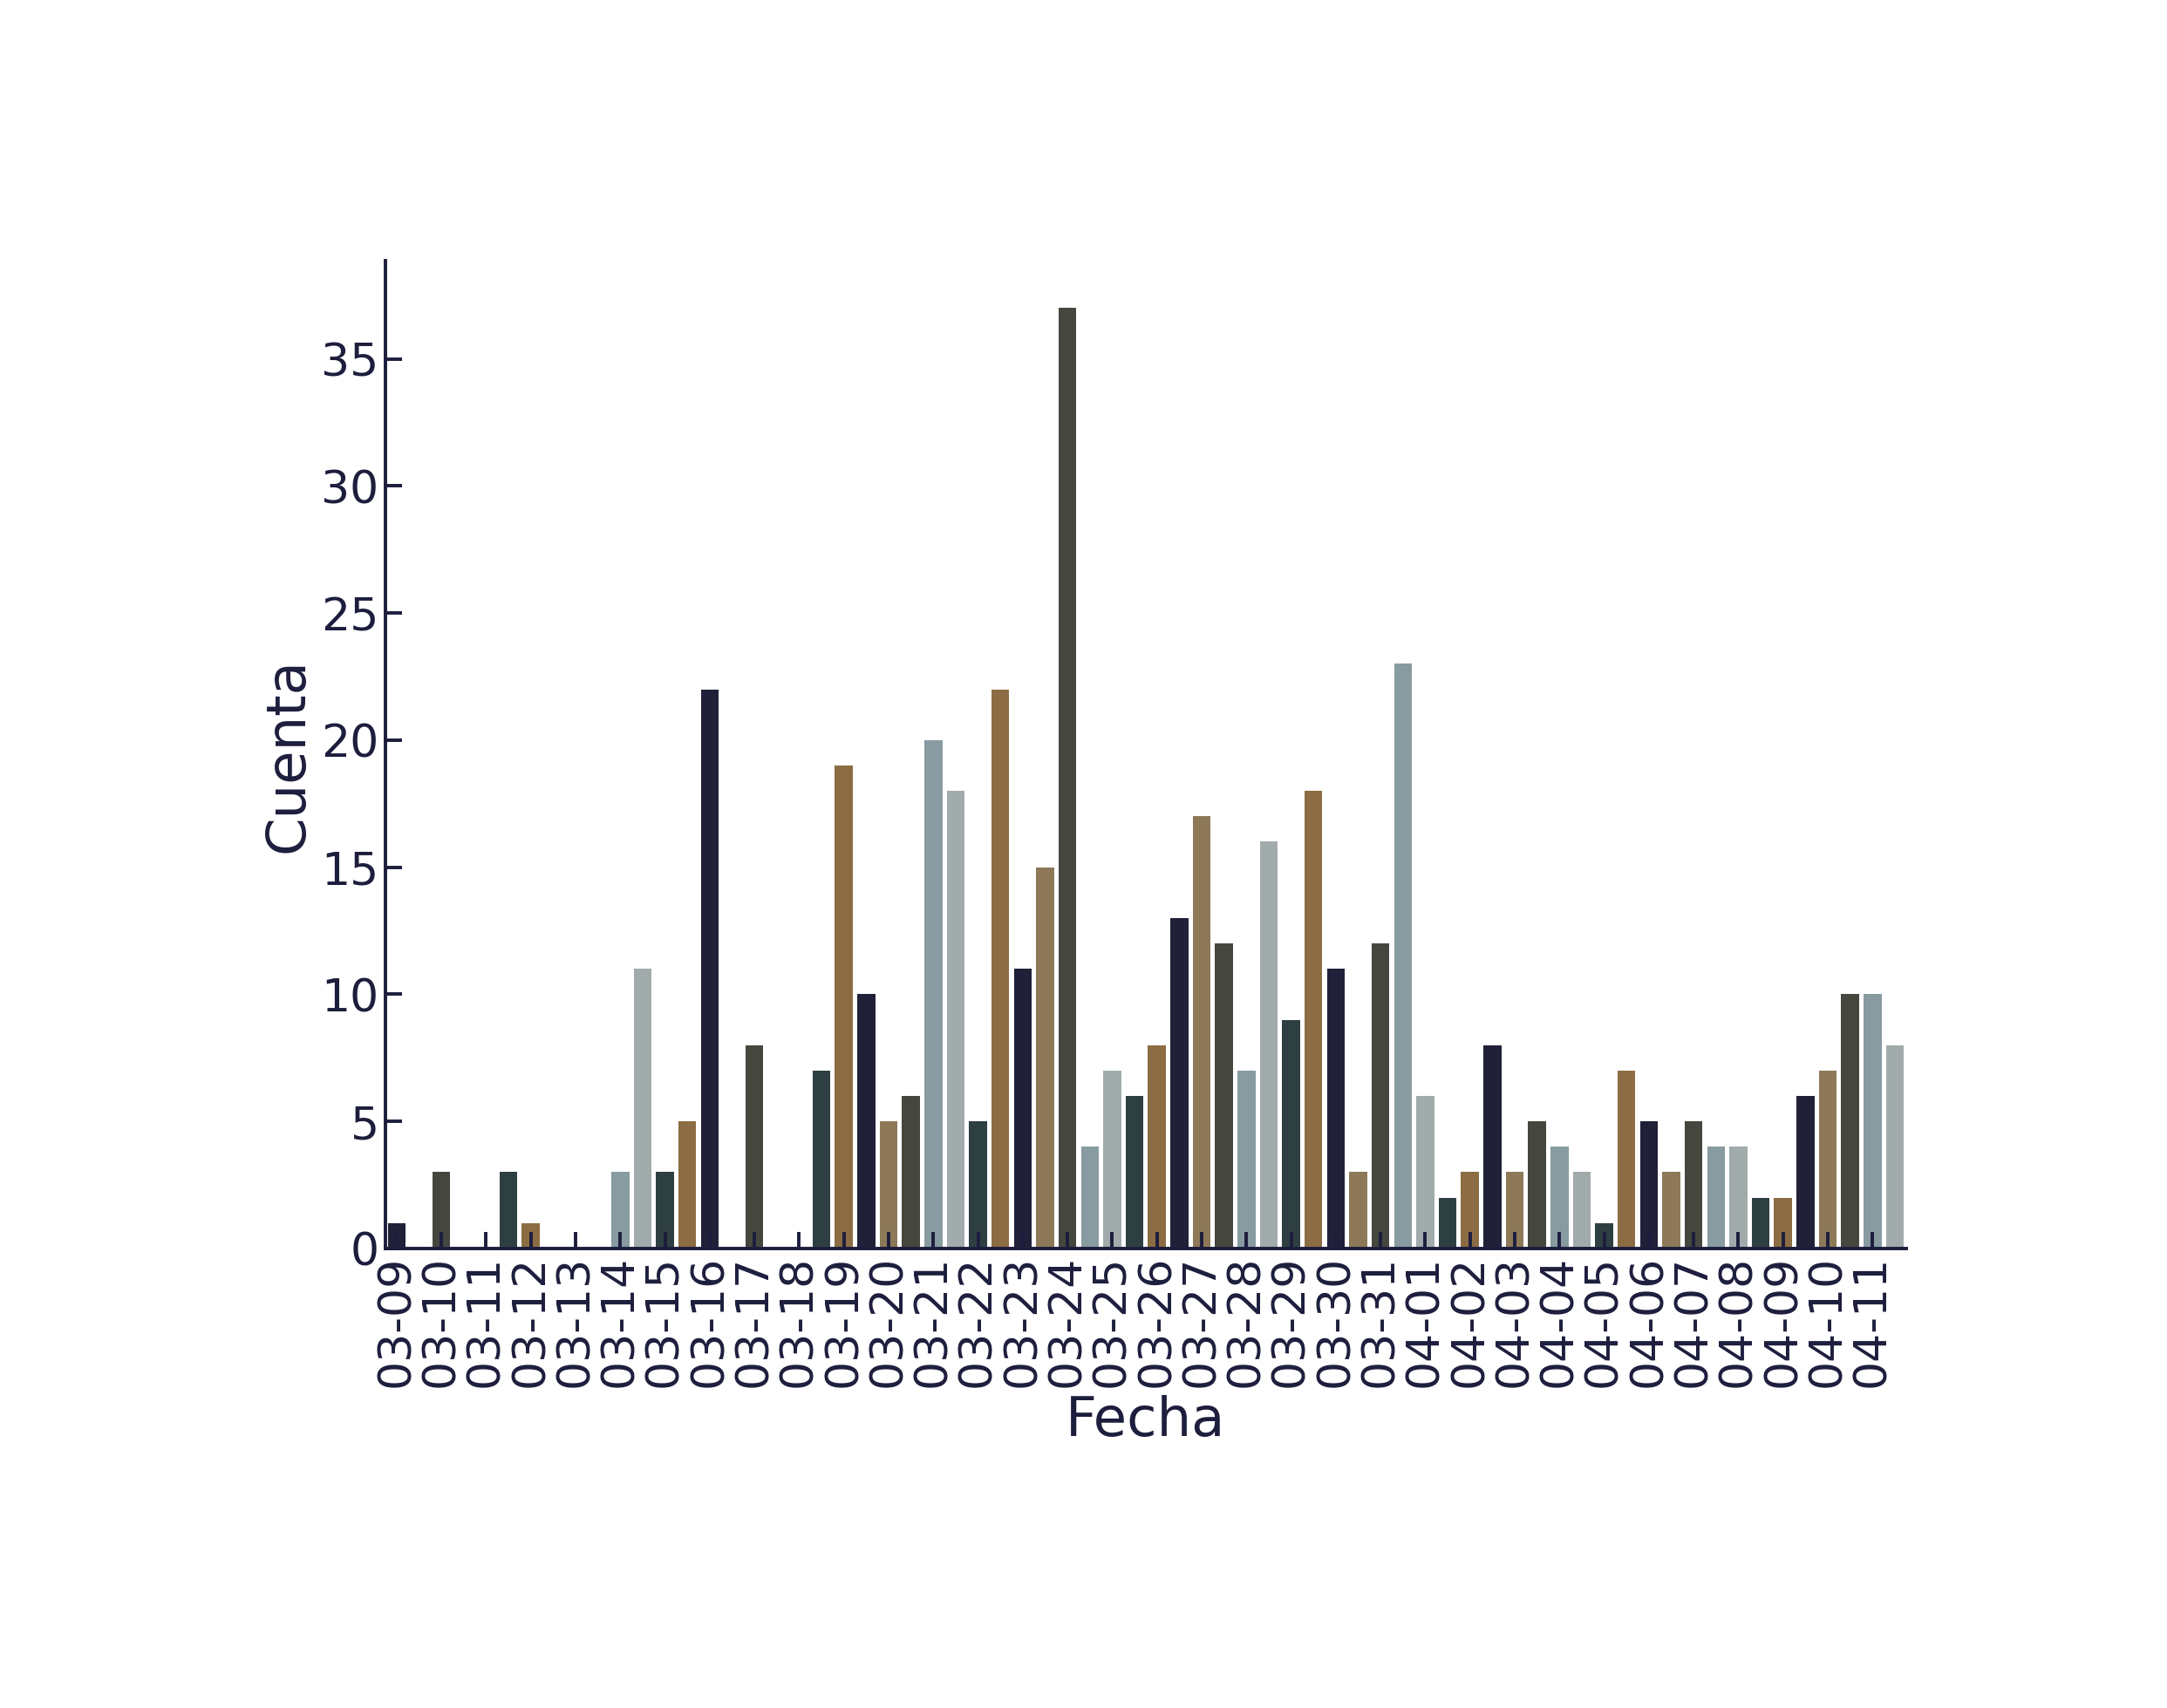

In [40]:
sns.set_context("talk")
plt.figure(figsize=(15,10))
ax = sns.barplot(x="fecha", y="cuenta", data=cuenta, palette=dp)
plt.xticks(rotation=90, fontsize=25)
plt.yticks(fontsize=25)
ax.set_xlabel("Fecha", fontsize=30)
ax.set_ylabel("Cuenta", fontsize=30)
ax.set_xticks(ax.get_xticks()[::2])
plt.savefig(f'confirmados_dia.png',bbox_inches='tight', transparent="True", pad_inches = 0)
plt.show()

## Recuperados

In [50]:
df_ant_changed = df_ant.copy()
df_ant_changed["fecha_recuperado"] = df_ant_changed["fecha_recuperado"].dropna()
cuenta_rec = pd.DataFrame(df_ant_changed.groupby("fecha_recuperado")["id_de_caso"].count()).reset_index()

cuenta_rec = cuenta_rec.rename(columns={"id_de_caso":"cuenta"})

idx = pd.date_range(cuenta_rec["fecha_recuperado"].min(), cuenta_rec["fecha_recuperado"].max())
all_dates = pd.DataFrame(idx, columns=["fecha"])
cuenta_rec = all_dates.merge(cuenta_rec, left_on="fecha", 
                right_on="fecha_recuperado", 
                how="left").drop("fecha_recuperado", axis=1).fillna(0)
cuenta_rec["fecha"] = cuenta_rec["fecha"].dt.strftime('%m-%d')
cuenta_rec.head()

,fecha,cuenta
0,03-15,1.0
1,03-16,0.0
2,03-17,0.0
3,03-18,0.0
4,03-19,0.0


In [92]:
cuenta_rec["cuenta"].sum()

314.0

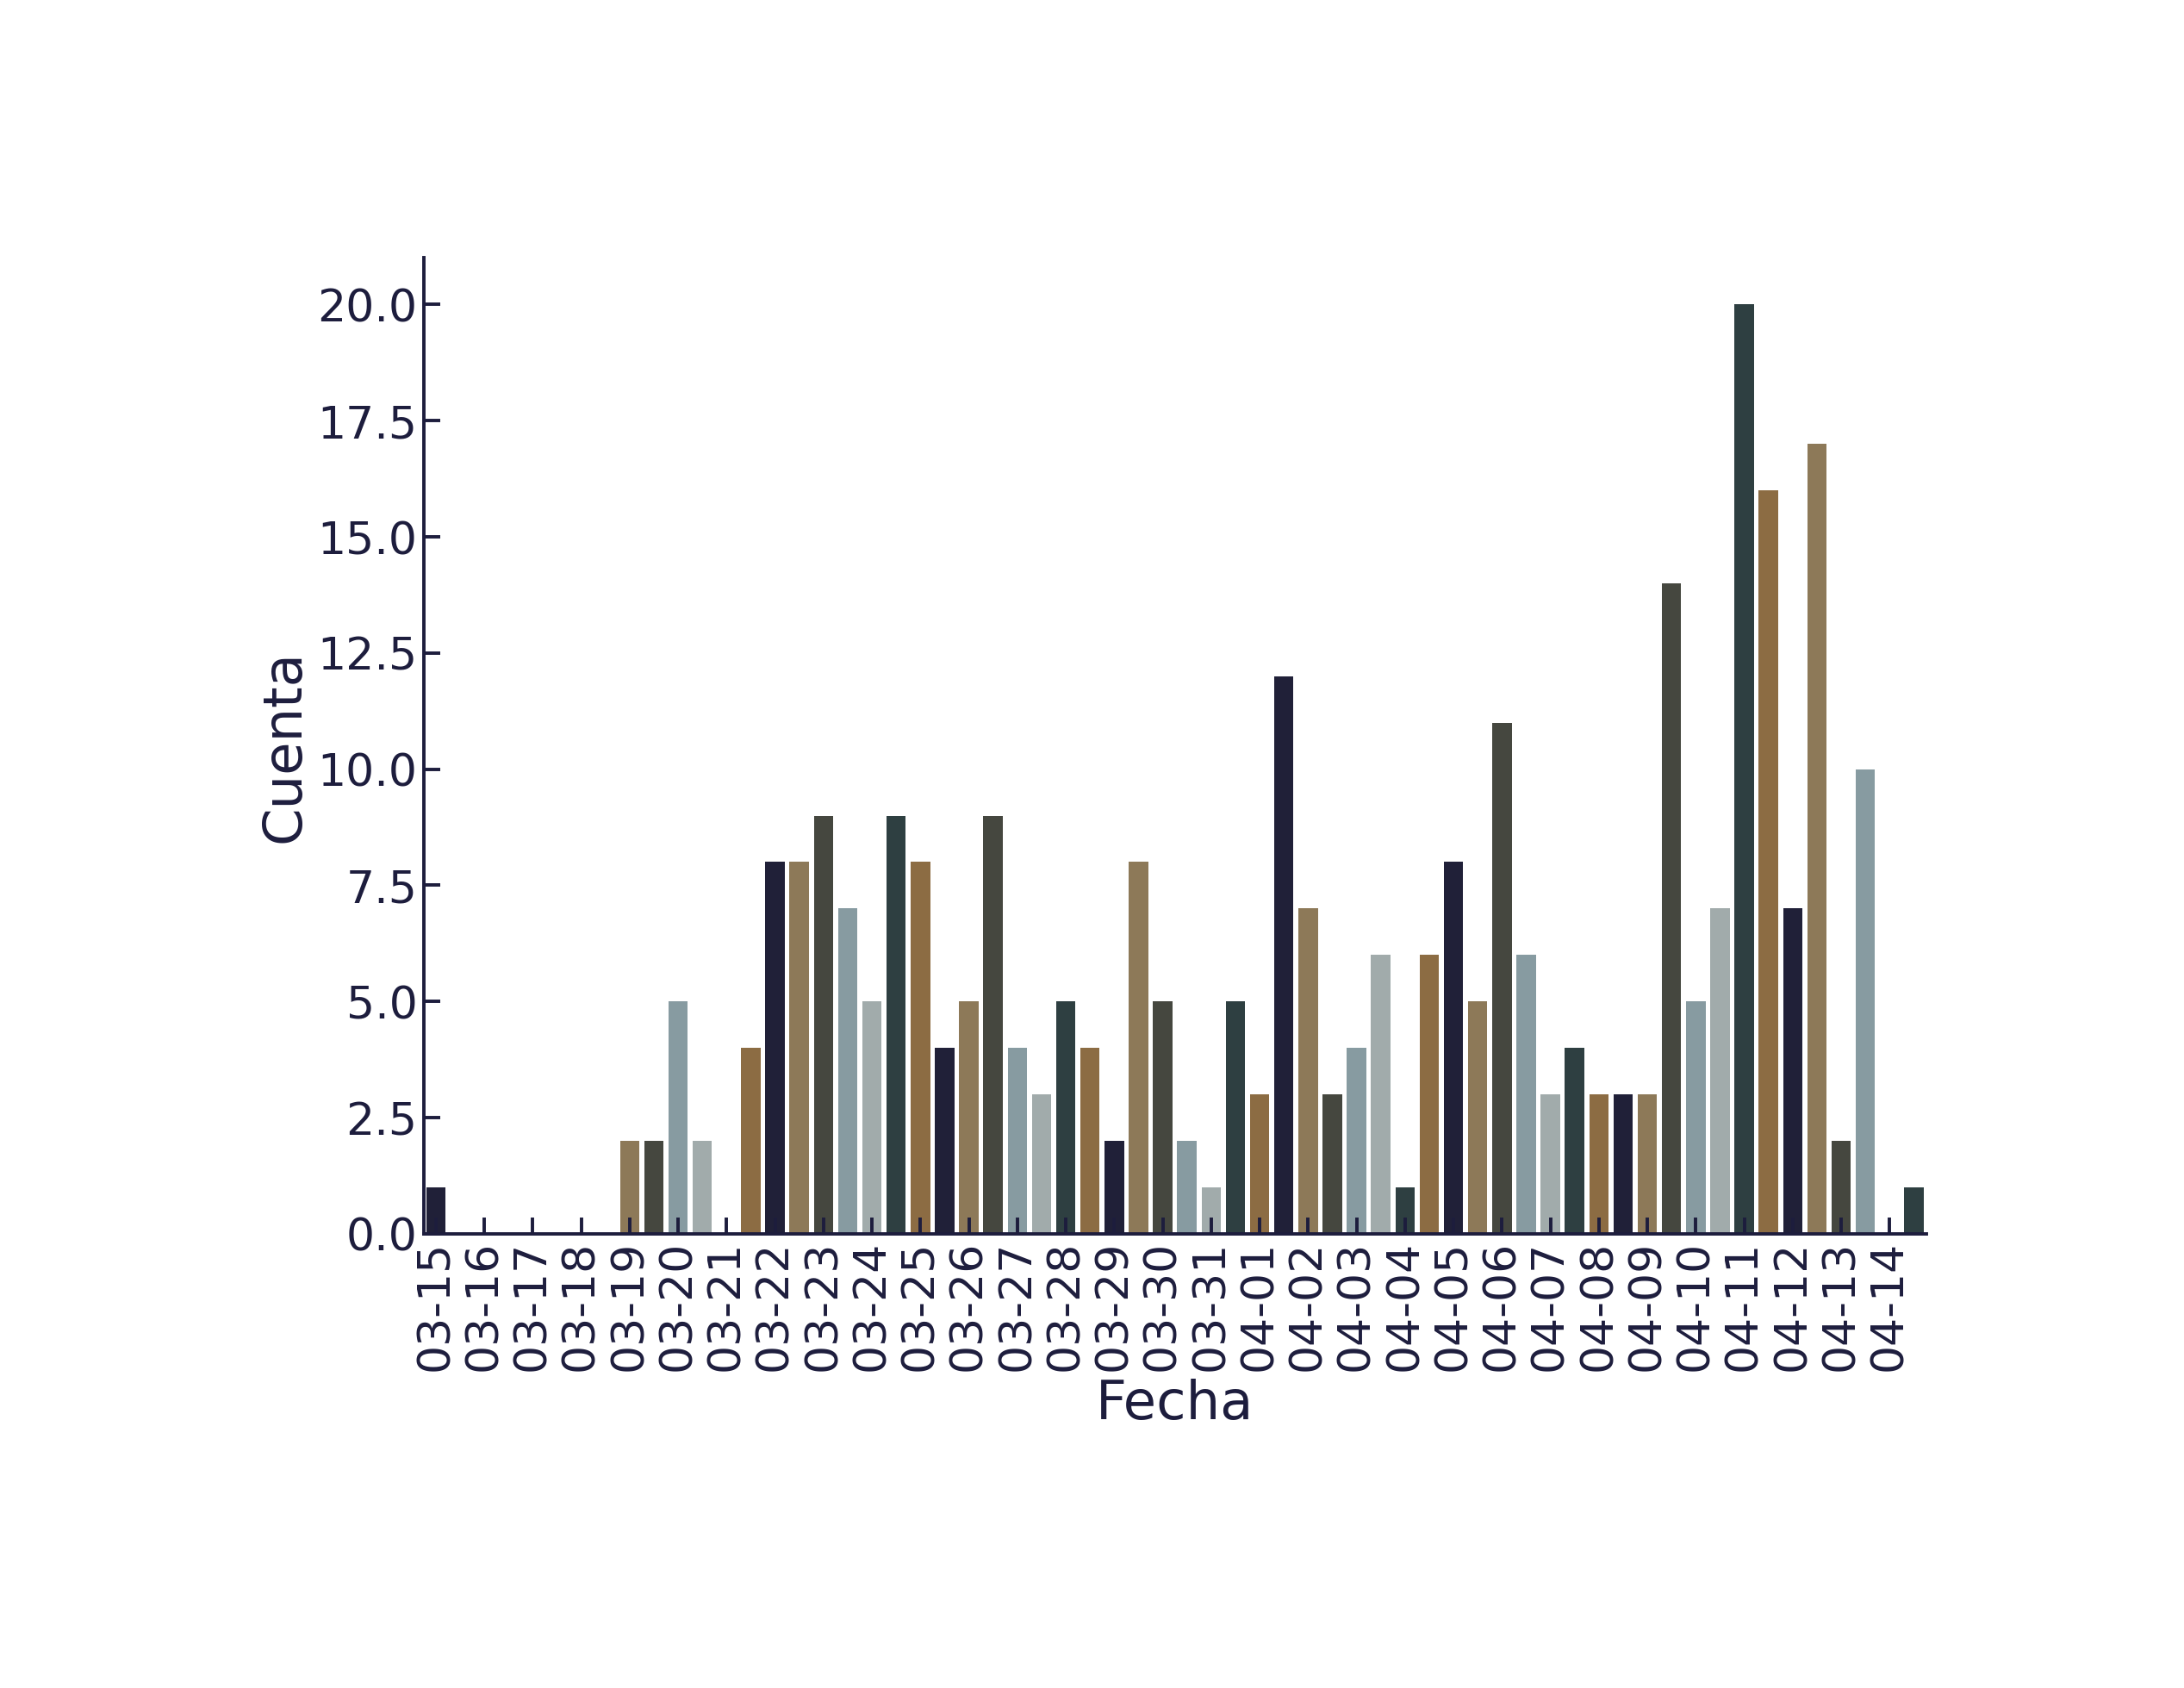

In [53]:
sns.set_context("talk")
plt.figure(figsize=(15,10))
ax = sns.barplot(x="fecha", y="cuenta", data=cuenta_rec, palette=dp)
plt.xticks(rotation=90, fontsize=25)
plt.yticks(fontsize=25)
ax.set_xlabel("Fecha", fontsize=30)
ax.set_ylabel("Cuenta", fontsize=30)
ax.set_xticks(ax.get_xticks()[::2])
plt.savefig(f'recuperados_dia.png',bbox_inches='tight', transparent="True", pad_inches = 0)
plt.show()

In [56]:
df_ant["estado"].value_counts()

LEVE            442
ASINTOMATICO     46
MODERADO         11
FALLECIDO         6
GRAVE             4
Name: estado, dtype: int64

In [62]:
df_male = df_ant[df_ant["sexo"] == "M"]
df_female = df_ant[df_ant["sexo"] == "F"]

male_death = df_male[df_male["estado"]=="FALLECIDO"]
female_death = df_female[df_female["estado"]=="FALLECIDO"]

m_cont = df_male.groupby(pd.cut(df_male["edad"], np.arange(0, 100, 4)))["id_de_caso"].count().to_frame("Hombres")
f_cont = df_female.groupby(pd.cut(df_female["edad"], np.arange(0, 100, 4)))["id_de_caso"].count().to_frame("Mujeres")

piramide = m_cont.join(f_cont).reset_index()

piramide["Hombres"] = -piramide["Hombres"]

piramide.head()

,edad,Hombres,Mujeres
0,"(0, 4]",-2,1
1,"(4, 8]",-5,6
2,"(8, 12]",-1,5
3,"(12, 16]",-3,5
4,"(16, 20]",-9,12


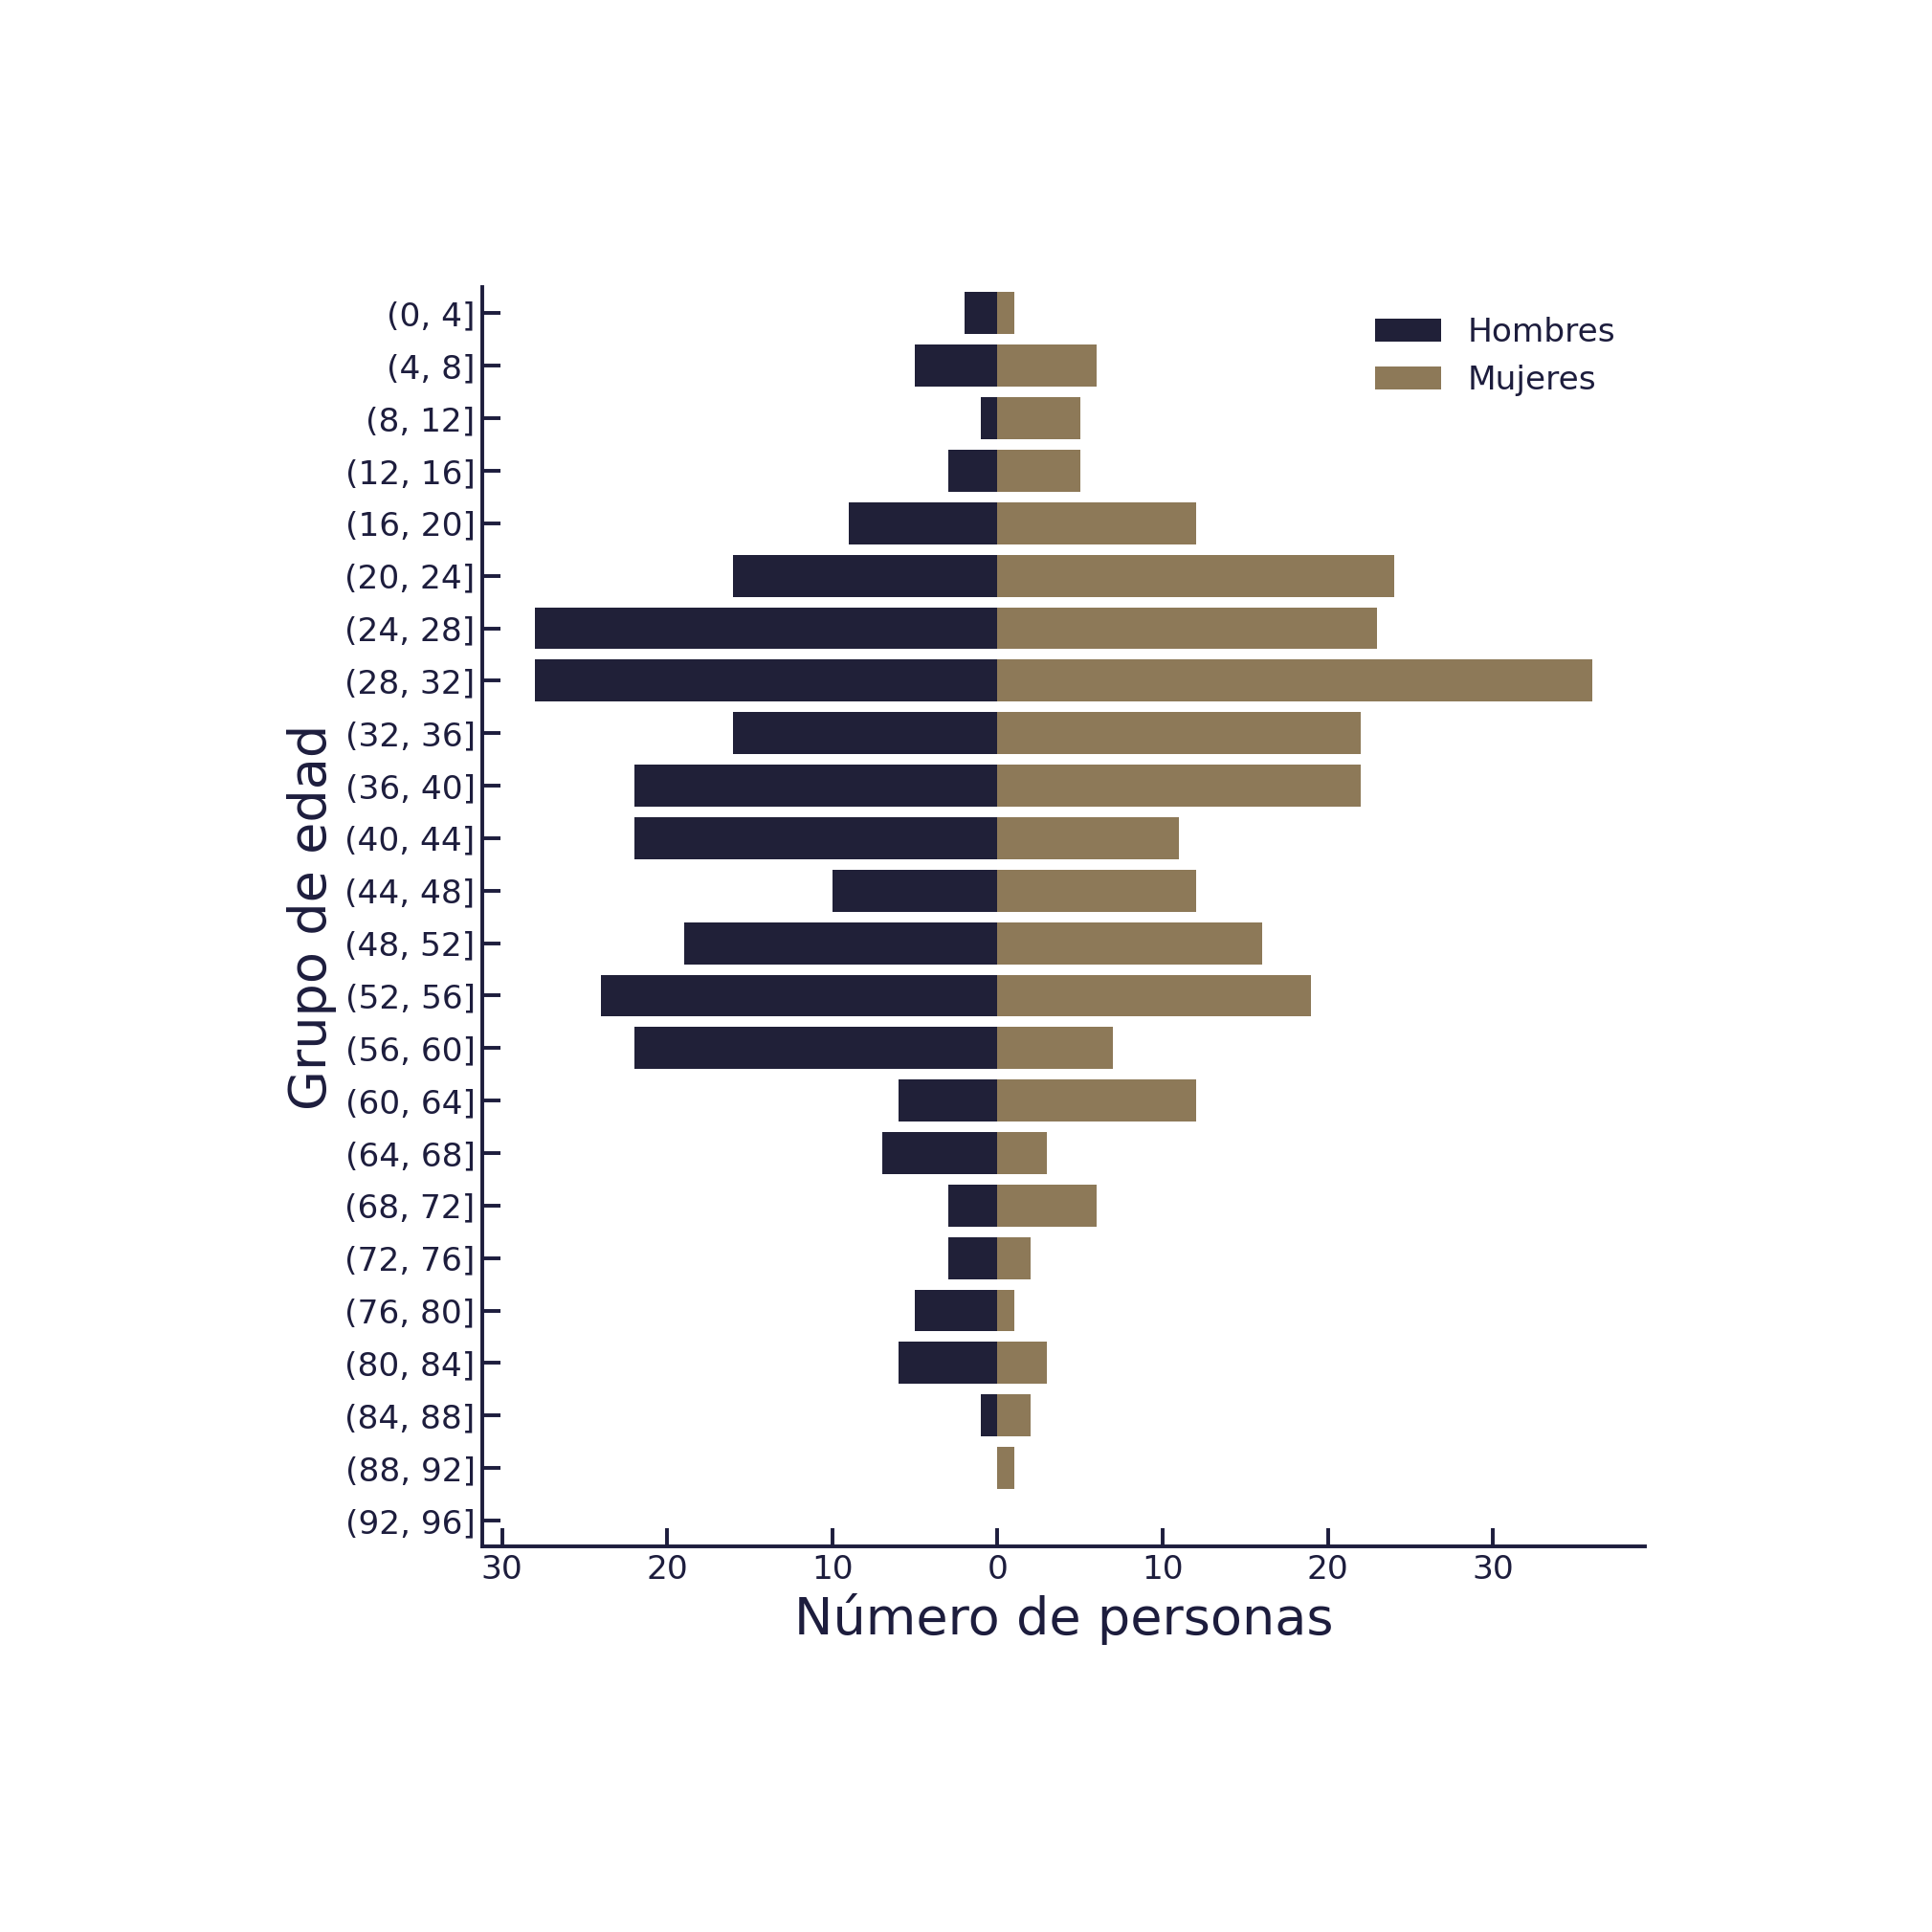

In [63]:
# sns.set_color_codes("pastel")
bar_plot = sns.barplot(x="Hombres",y="edad", color="#1c1c3c", label="Hombres",data = piramide)

bar_plot = sns.barplot(x="Mujeres",y="edad", color="#967B4F", label="Mujeres",data = piramide)


plt.ylabel('Grupo de edad',size=26)
plt.xlabel('Número de personas',size=26)

bar_plot.set_xticklabels(np.abs(list(bar_plot.get_xticks())).astype(int))
bar_plot.legend()  
plt.legend(framealpha=0.0)

plt.tight_layout()
plt.savefig(f'piramide.png',bbox_inches='tight', transparent="True", pad_inches = 0)

plt.show()

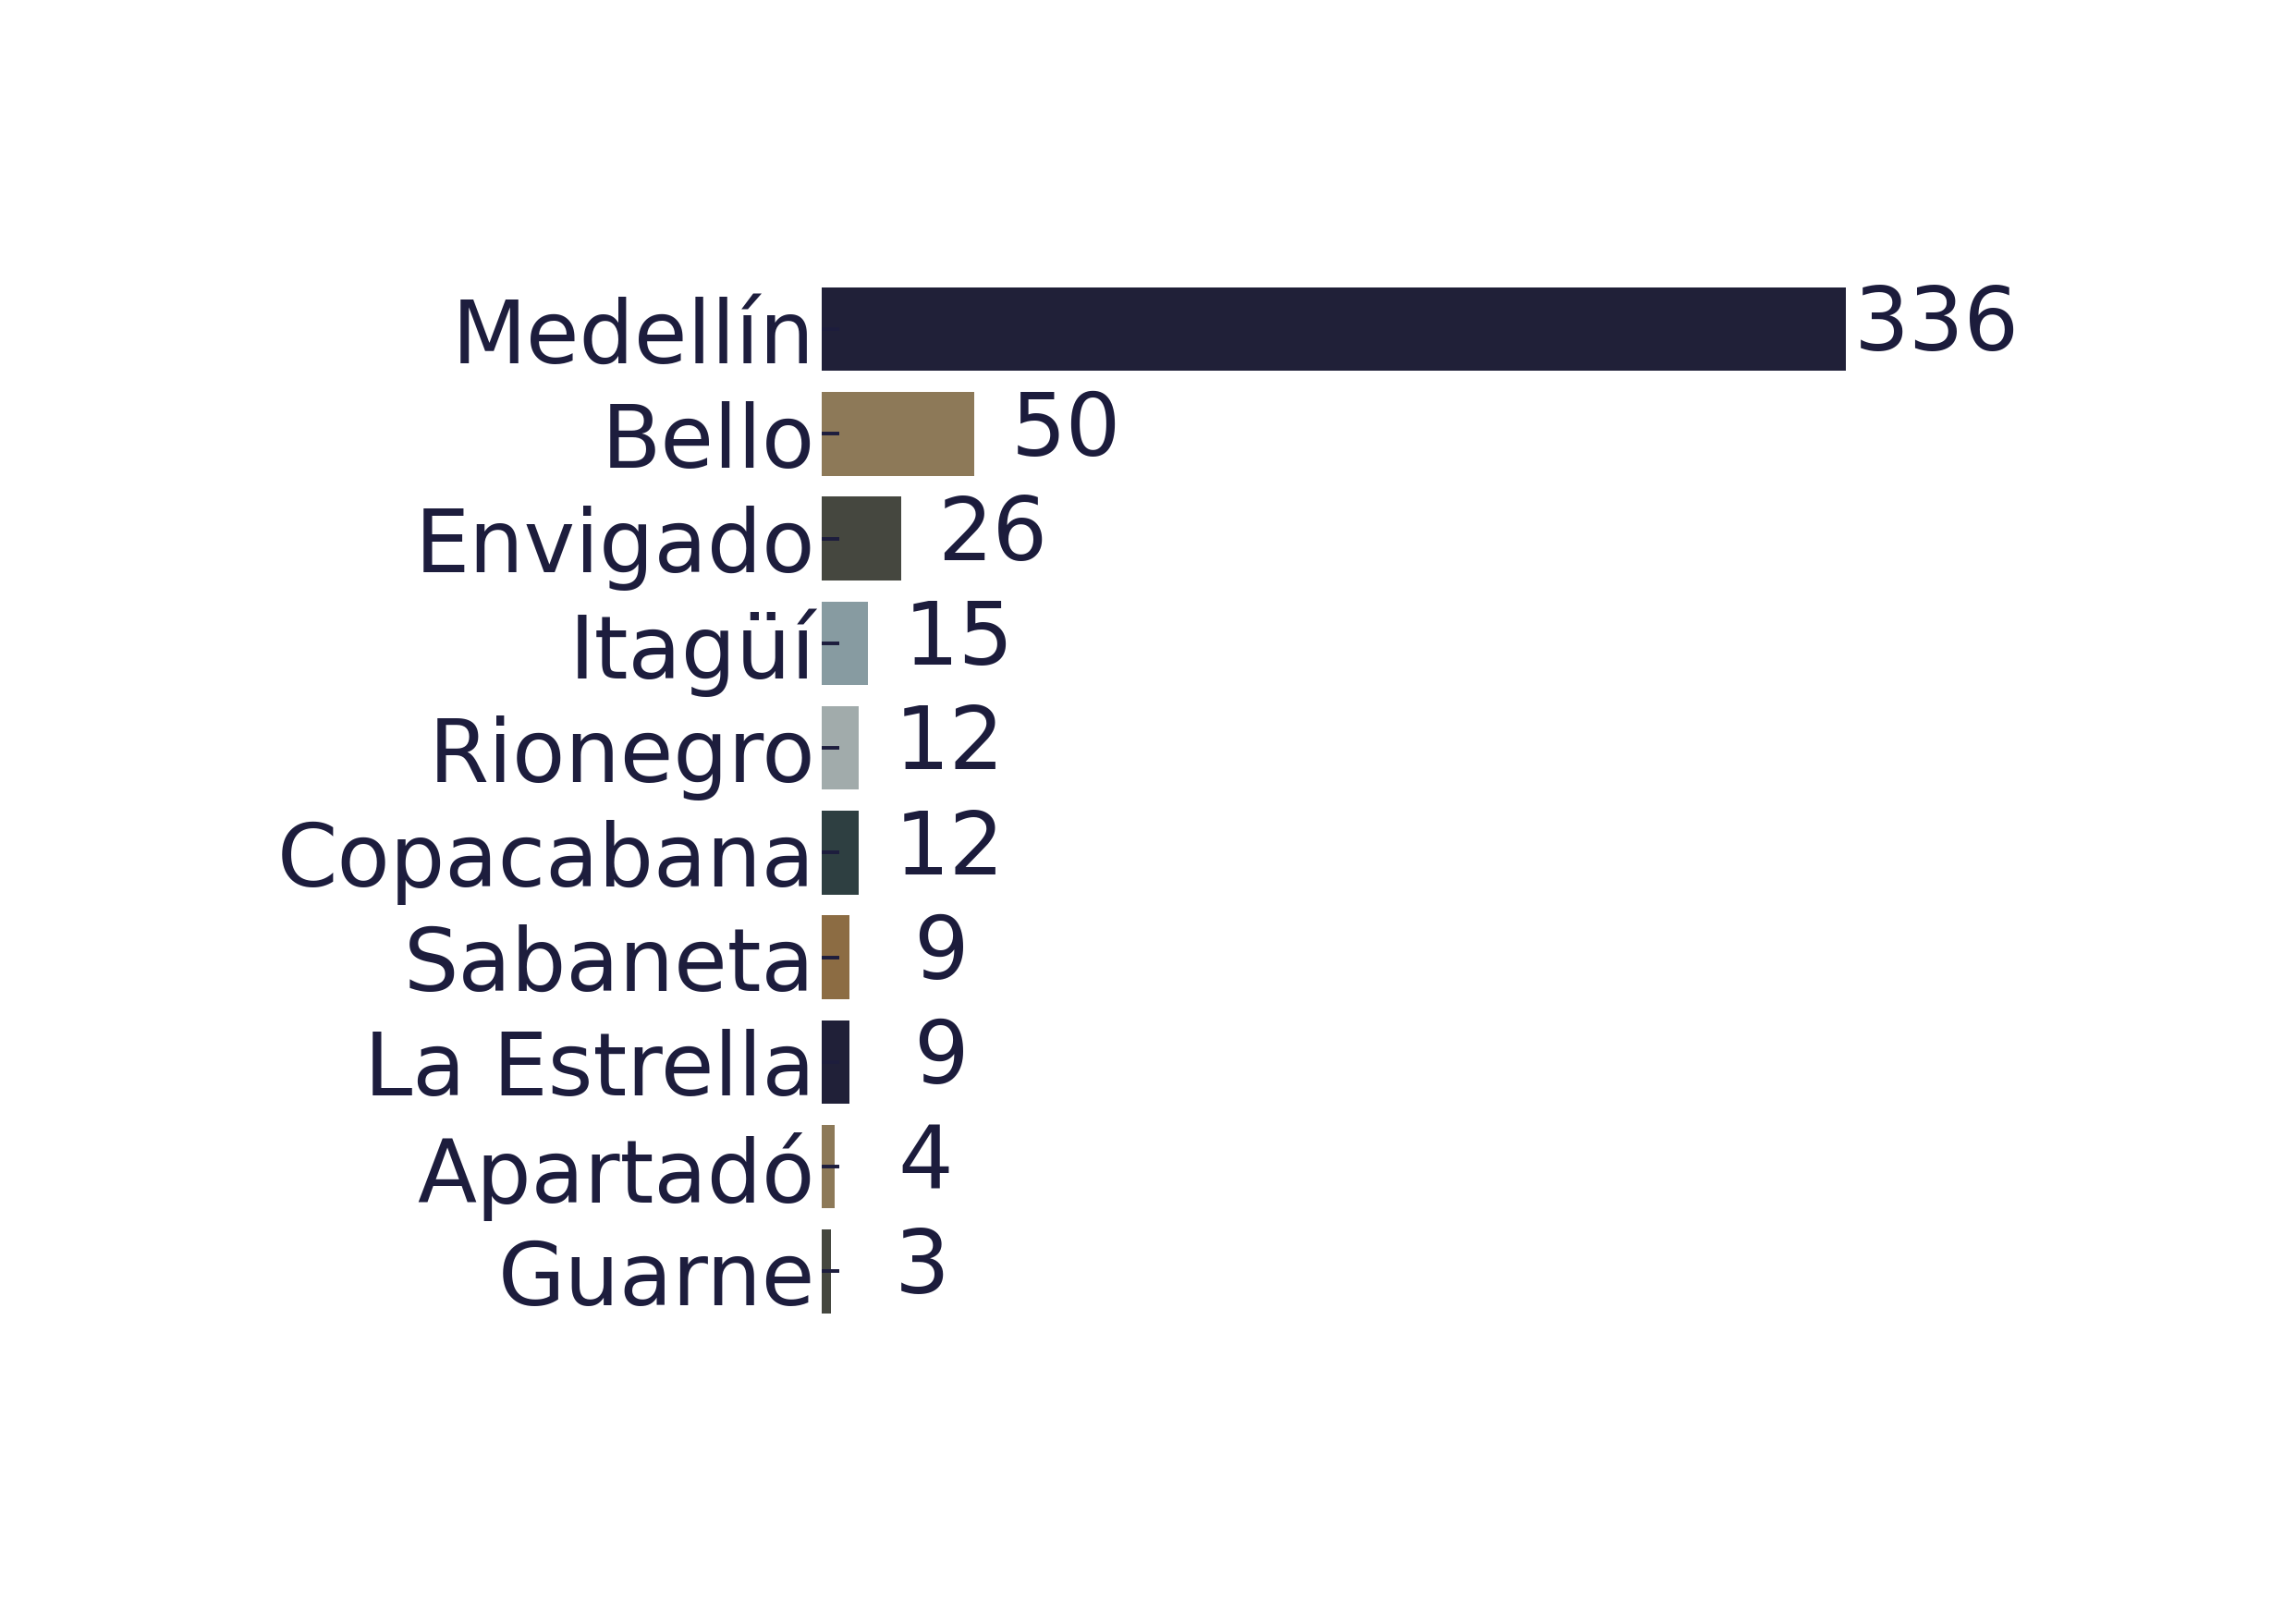

In [93]:
ciudades = df_ant.groupby("ciudad")["id_de_caso"].count().to_frame("cuenta").reset_index()
ciudades = ciudades.sort_values("cuenta", ascending=False).reset_index()
ax = sns.barplot(x = "cuenta", y="ciudad", data=ciudades.head(10), orient="h", palette=dp)

plt.grid(False)

ax.set_xlabel("", fontsize=30)
plt.xticks([])
plt.box(False)
ax.set_ylabel("", fontsize=30)



# jugar con estos valores
vertical_offset = 0.2
horizontal_offset = 30

ax.tick_params(axis='both', which='major', labelsize=45)
for index, row in ciudades.head(10).iterrows():
    ax.text(row["cuenta"] + horizontal_offset,index+vertical_offset, # posicion
            row["cuenta"], # texto
            color='#1c1c3c', 
            ha="center", 
            size=45)
    
plt.savefig(f'ciudades_antioquia.png',bbox_inches='tight', transparent="True", pad_inches = 0)
plt.show()

In [86]:
df_ant["atencion"].value_counts()

RECUPERADO      314
CASA            174
HOSPITAL         11
FALLECIDO         6
HOSPITAL UCI      4
Name: atencion, dtype: int64

In [88]:
df_ant["estado"].value_counts()

LEVE            442
ASINTOMATICO     46
MODERADO         11
FALLECIDO         6
GRAVE             4
Name: estado, dtype: int64

In [89]:
df_ant

,id_de_caso,Fecha de notificacion,codigo_divipola,ciudad,departamento,atencion,edad,sexo,tipo,estado,pa_s_de_procedencia,fis,fecha_de_muerte,Fecha de diagnóstico,fecha_recuperado,fecha_reporte_web,tiempo recuperacion,tiempo muerte
2,3,2020-03-07T00:00:00.000,5001,Medellín,Antioquia,RECUPERADO,50,F,IMPORTADO,LEVE,España,2020-02-29,NaT,2020-03-09,2020-03-15,2020-03-09T00:00:00.000,15.0,NaN
3,4,2020-03-09T00:00:00.000,5001,Medellín,Antioquia,RECUPERADO,55,M,RELACIONADO,LEVE,Colombia,2020-03-06,NaT,2020-03-11,2020-03-26,2020-03-11T00:00:00.000,20.0,NaN
4,5,2020-03-09T00:00:00.000,5001,Medellín,Antioquia,RECUPERADO,25,M,RELACIONADO,LEVE,Colombia,2020-03-08,NaT,2020-03-11,2020-03-23,2020-03-11T00:00:00.000,15.0,NaN
5,6,2020-03-10T00:00:00.000,5360,Itagüí,Antioquia,RECUPERADO,27,F,RELACIONADO,LEVE,Colombia,2020-03-06,NaT,2020-03-11,2020-03-26,2020-03-11T00:00:00.000,20.0,NaN
19,20,2020-03-11T00:00:00.000,5001,Medellín,Antioquia,RECUPERADO,26,F,RELACIONADO,LEVE,Colombia,2020-03-09,NaT,2020-03-14,2020-03-24,2020-03-14T00:00:00.000,15.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13971,14012,2020-05-13T00:00:00.000,5001,Medellín,Antioquia,CASA,27,M,EN ESTUDIO,LEVE,Colombia,2020-05-09,NaT,2020-05-15,NaT,2020-05-15T00:00:00.000,NaN,NaN
14177,14218,2020-05-14T00:00:00.000,5001,Medellín,Antioquia,CASA,19,F,EN ESTUDIO,LEVE,Colombia,2020-05-11,NaT,2020-05-15,NaT,2020-05-15T00:00:00.000,NaN,NaN
14188,14229,2020-05-12T00:00:00.000,5001,Medellín,Antioquia,CASA,73,M,EN ESTUDIO,LEVE,Colombia,2020-04-24,NaT,2020-05-15,NaT,2020-05-15T00:00:00.000,NaN,NaN
14214,14255,2020-05-09T00:00:00.000,5001,Medellín,Antioquia,CASA,5,F,RELACIONADO,ASINTOMATICO,Colombia,NaT,NaT,2020-05-15,NaT,2020-05-15T00:00:00.000,NaN,NaN
